# <div align="center">  Kobe Bryant Shot Probablity - Random Forest Model

## Introduction


Kobe Bryant, known for his unmatched skill, relentless drive, and "Mamba Mentality," made basketball look effortless as he drained shots from nearly every corner of the court. But what if we could take a step back and apply a little bit of data science to predict whether a Kobe shot would hit or miss? Well, that’s exactly what I’ve done!


So, step into the shoes of a basketball analyst as we dive into the numbers, the shots, and the legacy of one of the greatest players to ever play the game. Will the Mamba strike again, or will the numbers say otherwise? Let us find out

In [1]:
library(tidymodels)
library(ggplot2)
library(tidyverse)
library(vroom)

data <- vroom("/kaggle/input/kobe-bryant-shot-selection/data.csv.zip")


── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──



✔ broom        1.0.6      ✔ recipes      1.0.10
✔ dials        1.2.1      ✔ rsample      1.2.1 
✔ dplyr        1.1.4      ✔ tibble       3.2.1 
✔ ggplot2      3.5.1      ✔ tidyr        1.3.1 
✔ infer        1.0.7      ✔ tune         1.2.1 
✔ modeldata    1.4.0      ✔ workflows    1.1.4 
✔ parsnip      1.2.1      ✔ workflowsets 1.1.0 
✔ purrr        1.0.2      ✔ yardstick    1.3.1 



── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ stringr::fixed()    masks recipes::fixed()
✖ dplyr::lag()        masks stats::lag()
✖ readr::spec()       masks yardstick::spec()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘vroom’




The following objects are masked from ‘package:readr’:

    as.col_spec, col_character, col_date, col_datetime, col_double,
    col_factor, col_guess, col_integer, col_logical, col_number,
    col_skip, col_time, cols, cols_condense, cols_only, date_names,
    date_names_lang, date_names_langs, default_locale, fwf_cols,
    fwf_empty, fwf_positions, fwf_widths, locale, output_column,
    problems, spec




The following object is masked from ‘package:yardstick’:

    spec




The following object is masked from ‘package:scales’:

    col_factor




Rows: 30697 Columns: 25


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): action_type, combined_shot_type, season, shot_type, shot_zone_are...
dbl  (14): game_event_id, game_id, lat, loc_x, loc_y, lon, minutes_remaining...
date  (1): game_date



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## EDA

After loading in our data and libraries. We can look take a look at some important information from our dataset. This first visualization shows how the data is broken out on a court relative to a hoop. We can see different shot zones and every single shot Kobe took in his career by these different zones. 

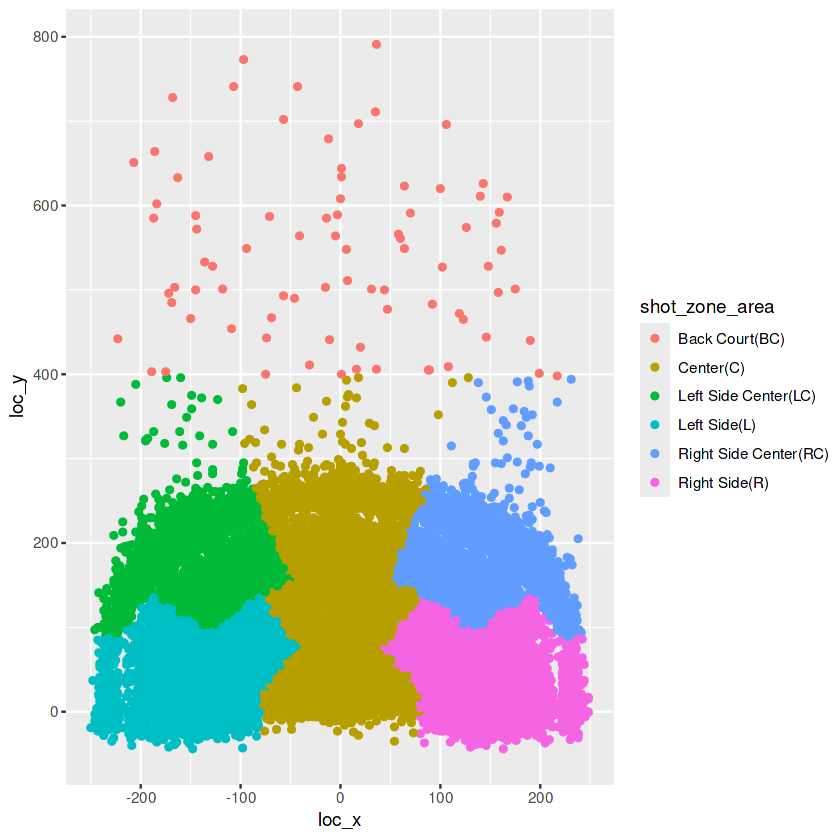

In [2]:
ggplot(data = data) +
  geom_point(mapping = aes(x = loc_x, y = loc_y, color = shot_zone_area))

Next we can see that every row of data is a shot but I wanted to understand how they classify each shot. We an see the Kobe really was the king of the jump shot and that shows being over 60% of all the shots he took in his career. 

In [3]:
action_type_summary <- data %>%
  count(action_type, sort = TRUE) %>%
  head(10)

print(action_type_summary)

# A tibble: 10 × 2
   action_type                  n
   <chr>                    <int>
 1 Jump Shot                18880
 2 Layup Shot                2567
 3 Driving Layup Shot        1978
 4 Turnaround Jump Shot      1057
 5 Fadeaway Jump Shot        1048
 6 Running Jump Shot          926
 7 Pullup Jump shot           476
 8 Turnaround Fadeaway shot   439
 9 Slam Dunk Shot             411
10 Reverse Layup Shot         395


The whole goal from this model is to predict the shots that we don't know the outcome. It appears that 5,000 shots make/miss data was removed so that is what we will be classifying!

In [4]:
shot_made_flag_summary <- data %>%
  mutate(has_data = !is.na(shot_made_flag)) %>%
  count(has_data)

print(shot_made_flag_summary)

# A tibble: 2 × 2
  has_data     n
  <lgl>    <int>
1 FALSE     5000
2 TRUE     25697


## Feature Engineering

* Time Remaing - This is an aggregation of the minutes and seconds remaining to have a single time remaining column in total seconds
* Matchup - The matchip feature determines whether or not the game was played @ Home or Away
* Season - Which season was the shot was taken in
* Shot Distance - Using euclidean distance formula this calculated the shot distance from the x and y coordinates of each shot

After creating these features I than dropped the rest of the columns to reduce noise and simplify cross validation

In [5]:
data$time_remaining = (data$minutes_remaining*60)+data$seconds_remaining #Time-remaining variable

data$matchup = ifelse(str_detect(data$matchup, 'vs.'), 'Home', 'Away') #Home vs. Away variable

data['season'] <- substr(str_split_fixed(data$season, '-',2)[,2],2,2) #Season variable

data$shot_distance <- sqrt((data$loc_x/10)^2 + (data$loc_y/10)^2) #Shot Distance using Euclidean Distance

data <- data %>%
  select(-c( 'team_id', 'team_name', 'shot_zone_range', 'lon', 'lat', 
             'seconds_remaining', 'minutes_remaining', 'game_event_id', 
             'game_id', 'loc_x', 'loc_y')) 

## Splitting Data & Recipe

The data like stated before has 5,000 shots that are undefined if the shot was made or missed. Therefore the data is split into test and train sets based on the shots_made_flag column with the test set being NA.

In my recipe I change the ID column because it can sometimes help in strengthening our predictions. I use step_novel, step_unknown to make sure there are no discrepencies between our test and train sets by assigning values for data that is found in one set but not the other. step_dummy is then used to encode all of our categorical variables.



In [6]:
data$shot_made_flag <- as.factor(data$shot_made_flag) #Set shot made as a factor instead of numeric

In [7]:
train <- data %>%
  filter(!is.na(shot_made_flag)) #Split the data into the train

test <- data %>% 
  filter(is.na(shot_made_flag)) #Split the data into the test

In [8]:
my_recipe <- recipe(shot_made_flag ~ ., data = train) %>%  #Create a recipe 
  step_novel(all_nominal_predictors()) %>% 
  step_unknown(all_nominal_predictors()) %>% 
  update_role(shot_id, new_role = "ID") %>% #Create a new ID column
  step_dummy(all_nominal_predictors()) %>% #Create dummy variables 
  step_naomit() #Remove NA values 

In [9]:
prep <- prep(my_recipe) #Prep Recipe to see if it works 
bake(prep, new_data = train) #Bake training set
bake(prep, new_data=test) #Bake testing set

period,playoffs,shot_distance,game_date,shot_id,time_remaining,shot_made_flag,action_type_Alley.Oop.Layup.shot,action_type_Cutting.Layup.Shot,action_type_Driving.Bank.shot,⋯,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,opponent_new,opponent_unknown
<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,15.700000,2000-10-31,2,622,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
1,0,16.860012,2000-10-31,3,465,1,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
1,0,22.286543,2000-10-31,4,412,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
2,0,0.000000,2000-10-31,5,379,1,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
3,0,14.541664,2000-10-31,6,572,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
3,0,0.000000,2000-10-31,7,532,1,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
3,0,12.605158,2000-10-31,9,372,1,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
3,0,12.928264,2000-10-31,10,216,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
3,0,25.589060,2000-10-31,11,116,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0


period,playoffs,shot_distance,game_date,shot_id,time_remaining,shot_made_flag,action_type_Alley.Oop.Layup.shot,action_type_Cutting.Layup.Shot,action_type_Driving.Bank.shot,⋯,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,opponent_new,opponent_unknown
<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,18.1859836,2000-10-31,1,627,NA,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
3,0,2.8017851,2000-10-31,8,485,NA,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
1,0,0.0000000,2000-11-01,17,1,NA,0,0,0,⋯,0,0,0,0,0,1,0,0,0,0
3,0,0.0000000,2000-11-01,20,646,NA,0,0,0,⋯,0,0,0,0,0,1,0,0,0,0
1,0,17.9847157,2000-11-04,33,686,NA,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
1,0,20.6242576,2000-11-04,34,658,NA,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
1,0,1.9026298,2000-11-04,35,453,NA,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
1,0,1.9209373,2000-11-04,36,358,NA,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
1,0,0.4123106,2000-11-04,37,249,NA,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0


In [10]:
library(doParallel)

num_cores <- parallel::detectCores()

cl <- makePSOCKcluster(num_cores)

registerDoParallel(cl)

Loading required package: foreach




Attaching package: ‘foreach’




The following objects are masked from ‘package:purrr’:

    accumulate, when




Loading required package: iterators



Loading required package: parallel



## Random Forest

Out of all the models that I tried on this data, Random forest performed the best. I allowed for the min_n and mtry hyperparamters to be tuned so that we can find the best tune of our model using cross validation.

In [11]:
my_mod_forest <- rand_forest(mtry = tune(), #Create a random forest model with 500 trees and tuned attributes 
                             min_n=tune(),
                             trees= 800) %>%
  set_engine("ranger") %>%
  set_mode("classification")

In [12]:
workflow_forest <- workflow() %>% # Create a workflow with model & recipe
  add_recipe(my_recipe) %>%
  add_model(my_mod_forest)

tuning_grid <- grid_regular(mtry(range = c(1,(ncol(train)-1))),
                            min_n(),
                            levels = 3)

folds <- vfold_cv(train, v = 5, repeats=1) #decide how many folds you want to do for k-fold cross validation


After setting up everthing for our model and cross validation we run it for results using the mn_log_loss metric. This part is the slowest but from it we learn our best tunes for our Random Forest Model!

In [13]:
CV_results_forest <- workflow_forest %>% #cross validate and tune values 
  tune_grid(resamples=folds,
            grid=tuning_grid,
            metrics=metric_set(mn_log_loss))

In [14]:
show_notes(.Last.tune.result)

Great job! No notes to show.


In [15]:
bestTune <- CV_results_forest %>% # Find best tuning parameters
  select_best(metric = "mn_log_loss")

print(bestTune)

# A tibble: 1 × 3
   mtry min_n .config             
  <int> <int> <chr>               
1    14    40 Preprocessor1_Model9


## Predictions

After finding our best model we now using these results to create predictions on our test set! First I finalize the workflow to use the best tuned hyperparameters from before to make our predictions. Last we format our predictions to meet the Kaggle competition submission requirements and write our predictions to a csv!

In [16]:
final_wf_forest <- workflow_forest %>% # Finalize workflow 
  finalize_workflow(bestTune) %>%
  fit(data = train)

predictions_forest <- final_wf_forest %>% #Predict Values 
  predict(test,
          type="prob")

predictions_forest <- predictions_forest %>% 
  bind_cols(., test) %>%   
  select(shot_id, .pred_1) %>%   
  rename(shot_made_flag = .pred_1)

In [17]:
vroom_write(x=predictions_forest, file="kobe3.csv", delim = ",")